## Feature Engineering

### Imports

In [1]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:90% !important; } p, ul {max-width:␣
,→40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png {␣
,→display: flex; justify-content: center;}</style>"""))

import pandas as pd
import numpy as np
import os
import difflib
import re
import spacy
from   spacy.matcher import Matcher
from   spacy         import displacy
from   matplotlib    import pyplot as plt
from   pylab         import rcParams
from IPython.display import clear_output

import en_core_web_sm
nlp    = en_core_web_sm.load()

import en_core_web_lg
nlp_lg = spacy.load('en_core_web_lg')

import networkx as nx


## Functions

In [2]:
# Returns a list of tuples containing all paths and files of a specific type in a directory and its sub directory
# Pass an extension to override .json
def listAllFiles(folder, extension = '.json'):
    files = list()
    for (dirpath, dirnames, filenames) in os.walk(folder):
        files += [(dirpath, file) for file in filenames if file.endswith(extension)]
    return files

In [3]:
# Filters the list files and paths down to either the first N number of files, or a specific file
def filterFilePairs(count, file, filePairs):
    
    # If no specific file is passed
    if file == None:
        
        # Check if specific count required
        if count > 0:

            # Filter down to count
            return filePairs[:count]
        
        else:
                
            # Return all of them    
            return filePairs
        
    # Use a specific file
    for filePair in filePairs:

        # This gets the foler of the filepairs and matches it to the filename you put it
        fileName = [file for file in filePair if file.endswith('.csv')][0]
        fileName = fileName.split('\\')[-1]
        if dropExtensions(fileName) == file:

            return [filePair]

    print('ERROR: File not found')
    print('File requested: specificFile')

In [4]:
# This garbage needed to handle the data from the original project
def dropExtensions(fileName):
    if fileName.endswith('.txt.txt.csv'):
        return fileName.replace('.txt.txt.csv', '')
    
    if fileName.endswith('.txt.csv'):
        return fileName.replace('.txt.csv', '')

    if fileName.endswith('.csv'):
        return fileName.replace('.csv', '')

In [5]:
# Find annotated text file for an individual file
def findAnnotatedTextFile(file):
    
    for dirPath, subdirs, files in os.walk('ExtractedAnnotatedData'):
        for f in files:
            if f == file:
                return True, os.path.join(dirPath, f)
                    
    return False, None

In [6]:
def AddRelationshipFeatures(df, doc):

    df['Same_Sentence']       = [1 if doc[df.loc[X]['Start_Token_Species']].sent == 
                                   doc[df.loc[X]['Start_Token_Location']].sent
                                       else 0
                                       for X in df.index]
    
    df.Same_Sentence          = df.Same_Sentence.astype('int8')
    
    df['Num_Tokens_Between']  = [max(df.loc[X]['Start_Token_Species'], 
                                                 df.loc[X]['Start_Token_Location']) 
                                             - min(df.loc[X]['End_Token_Species'], 
                                                   df.loc[X]['End_Token_Location'])
                                             for X in df.index]
    
    df['Num_Words_Between']  = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.is_alpha])
                                             for X in df.index]
    
    df['Num_Verbs_Between']  = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='VERB'])
                                             for X in df.index]
    
    df['Num_Nouns_Between']  = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='NOUN'])
                                             for X in df.index]
    
    df['Num_Preps_Between']  = [len([token for token in doc[min(df.loc[X]['End_Token_Species'], 
                                                                             df.loc[X]['End_Token_Location']):
                                                                         max(df.loc[X]['Start_Token_Species'], 
                                                                             df.loc[X]['Start_Token_Location'])]
                                                  if token.pos_ =='ADP'])
                                             for X in df.index]

    df['Preposition_Between'] = df['Num_Preps_Between']  > 0

    df['Preposition_Between'] = (df['Num_Preps_Between'] > 0).astype('int8')

    df['Dependency_Steps']    = countDependencySteps(zip(df.Start_Token_Species,
                                                         df.End_Token_Species,
                                                         df.Start_Token_Location,
                                                         df.End_Token_Location,
                                                         df.Same_Sentence), doc)
    return df

In [7]:
def countDependencySteps (tokens, doc):

    results=[]
    for start_token_spec, end_token_spec, start_token_loc, end_token_loc, samesent  in tokens:
        if samesent == 0:
            results.append(999)
        else:
            sentence = doc[start_token_spec].sent
            edges    = []

            for token in sentence:
                for child in token.children:
                    edges.append(('{0}'.format(token.lower_),
                                  '{0}'.format(child.lower_)))

            graph      = nx.Graph(edges)
            pathlength = 999
            minpath    = 999
            
            # Iterate through each word in the sentence
            for i in range(start_token_spec, end_token_spec):
                
                entity1    = doc[i].text.lower()

                # Check it is in the sentence graph
                if entity1 in graph:

                    # Iterate through each other word in the sentence
                    for j in range(start_token_loc, end_token_loc):
                        entity2 = doc[j].text.lower()

                        # Check the other word is in the graph
                        if entity2 in graph:

                            # Check there is a path between the nodes 
                            if nx.has_path(graph, entity1, entity2) == True:
                                
                                # Check if it's a smaller path than the current smallest path
                                pathlength = nx.shortest_path_length(graph, entity1, entity2) # Get the path length
                                if pathlength < minpath:
                                    minpath = pathlength
                                
            results.append(minpath)
                
    return results

In [8]:
def addExtraFeaturestoAll(df):
    
    new_df = pd.DataFrame()
    for source in df.AnnTxtFile.unique():
        
        df_sub   = df[df.AnnTxtFile == source].copy()

        file     = open(source, encoding="utf-8")
        
        document = file.read()
        
        doc      = nlp_lg(document)
        
        df_sub   = AddRelationshipFeatures(df_sub, doc)

        new_df   = pd.concat([new_df, df_sub])

        new_df.reset_index(drop=True, inplace=True)
        
    return new_df

In [9]:
def textToBOW(doc):
    BOW    = {}
    length = 0
    
    for token in doc:
        if token.is_alpha:
            length += 1
            
            if token.text in BOW:
                BOW[token.text] += 1
                
            if token.text not in BOW:
                BOW[token.text]  = 1

    for key in BOW.keys():
        BOW[key] = BOW[key] / length
        
    return BOW

### Script

In [10]:
# These next two lines need to match the filter parameters from the NER Metrics and Matrix Creation notebook in order to get accurate results
# Example: 10.1007_BF00238925.pdf
specificFile    = 'Archer2017_Article_EndolithicMicrobialDiversityIn'

# To work with all files, set this to zero
fileCount       = 0

# Load files
print('STAGE: Load all files in metrics folder')
allFiles        = listAllFiles('Metrics\\Relationships\\DocumentSpecific\\', '.csv')

# Filter to file count or file name
print('STAGE: Filter files')
filePairs       = filterFilePairs(fileCount, specificFile, allFiles)

# Load all possible relationships.csv
print('STAGE: Load all relationships csv')
allPossibleRelationships = pd.read_csv('Metrics\\Relationships\\allPossible.csv', 
                                        index_col = 0, 
                                        dtype     = {'Tagged_Relationship': 'Int8'})
col_to_downcast          = [col for col in allPossibleRelationships.columns if allPossibleRelationships[col].dtype == int]
allPossibleRelationships[col_to_downcast] = allPossibleRelationships[col_to_downcast].apply(pd.to_numeric, downcast = 'integer')

# Add extra features to all possible relationships.csv
print('STAGE: Add extra features')
allPossibleRelationships = addExtraFeaturestoAll(allPossibleRelationships)

# Export to csv
print('STAGE: Export to working dataset')
allPossibleRelationships.to_csv('Metrics\\DataSet\\workingDataset.csv')

# Clear output on success
clear_output(wait = True)
print("Success")

Success


In [11]:
# I'm not sure what this section is for but it was here so I improved it and kept it just in case
# Iterate through the files
print('ITERATE: Through metrics files')
for filePair in filePairs:
    print('')
    print(os.path.join(filePair[0], filePair[1]))
    
    # Load the documents
    print('COMMAND: Load metrics documents')
    oneDocRelationships = pd.read_csv(os.path.join(filePair[0], filePair[1]), 
                                       index_col = 0, 
                                       dtype     = {'Tagged_Relationship': np.int8})
    col_to_downcast     = [col for col in oneDocRelationships.columns if oneDocRelationships[col].dtype == int]
    oneDocRelationships[col_to_downcast] = oneDocRelationships[col_to_downcast].apply(pd.to_numeric, downcast = 'integer')
    print('RESULT:  OK')
    
    # Find the annotated text file 
    print('COMMAND: Find and load annotated text file')
    result, annotatedTextFile = findAnnotatedTextFile(filePair[1].replace('.csv', ''))
    if (result == False):
        print('ERROR: Could not find files')
    else:
        file = open(annotatedTextFile, encoding='utf-8')
        document = file.read()
        file.close()
        doc = nlp_lg(document)
    print('RESULT:  OK')
    
    # Bag of words the document
    print('COMMAND: Bag of Words the document')
    bagofwords = textToBOW(doc)
    print('RESULT:  OK')
    
# Clear output on success
clear_output(wait = True)
print("Success")
    

Success


### Print outs

In [12]:
cols_of_interest = ['inAbstract300_Species', 
                    'inAbstract500_Species', 
                    'max_TFISF_Species', 
                    'Sent_Start_Species',
                    'inAbstract300_Location', 
                    'inAbstract500_Location', 
                    'max_TFISF_Location', 
                    'Sent_Start_Location', 
                    'Tagged_Relationship', 
                    'Same_Sentence', 
                    'Num_Tokens_Between',
                    'Num_Words_Between', 
                    'Num_Verbs_Between', 
                    'Num_Nouns_Between', 
                    'Num_Preps_Between',
                    'Preposition_Between', 
                    'Dependency_Steps']

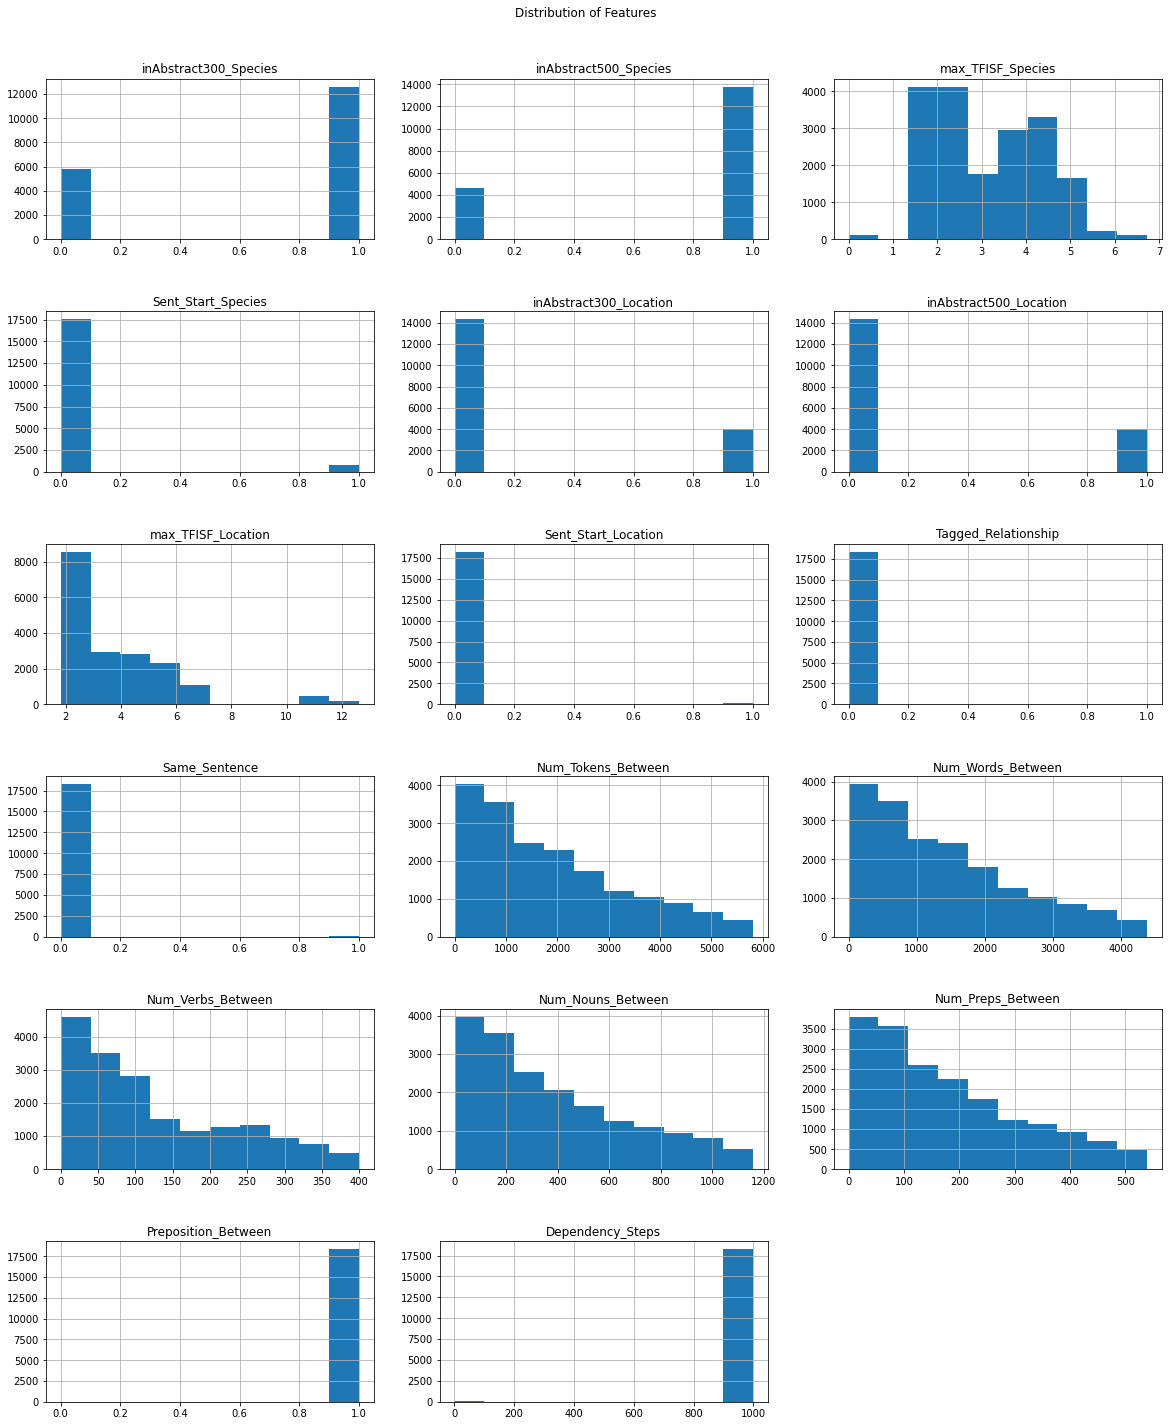

In [13]:
plt.figure(figsize = (20,50))
i = 1

for col in cols_of_interest: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    allPossibleRelationships[col].hist()
    ax.set_title(col)
    i += 1
plt.subplots_adjust(hspace = .45)
plt.suptitle("Distribution of Features", y = 0.9)
plt.show()  

In [14]:
possible_transformations = ['max_TFISF_Species', 
                            'max_TFISF_Location', 
                            'Num_Tokens_Between',
                            'Num_Words_Between', 
                            'Num_Verbs_Between',  
                            'Num_Nouns_Between', 
                            'Num_Preps_Between']

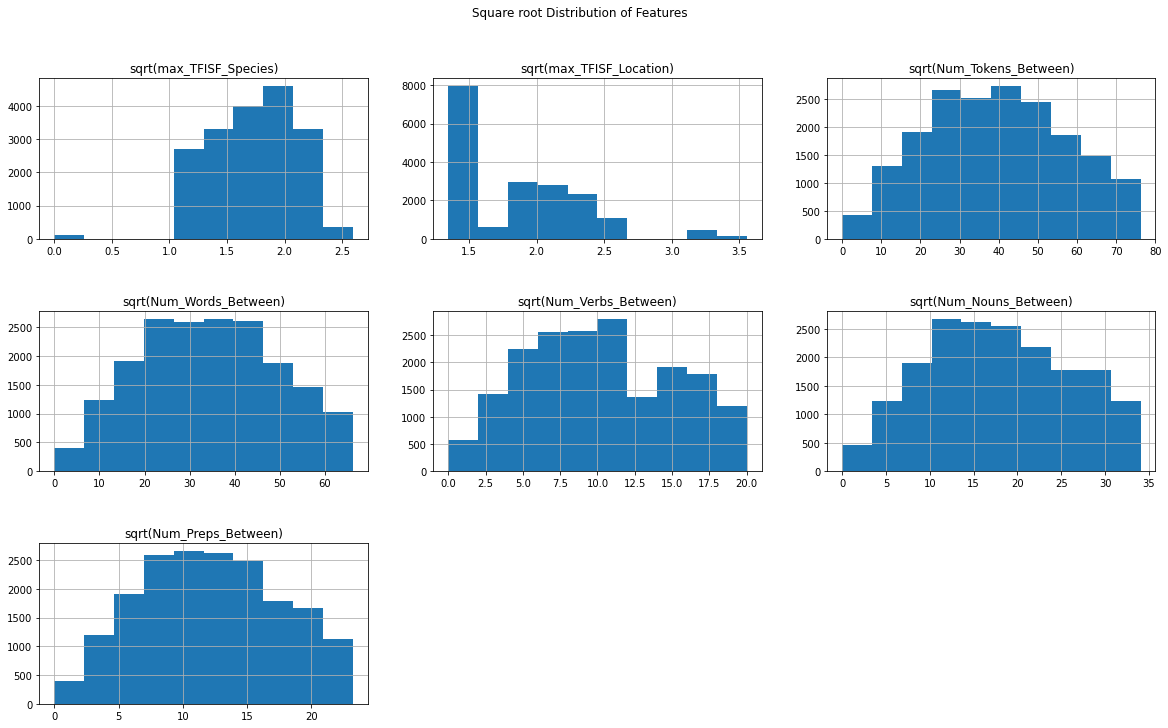

In [15]:
plt.figure(figsize=(20,50))
i=1
for col in possible_transformations: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    np.sqrt(allPossibleRelationships[col]).hist()
    ax.set_title('sqrt('+col+')')
    i += 1
plt.subplots_adjust(hspace=.45)
plt.suptitle("Square root Distribution of Features", y=0.9)
plt.show()  

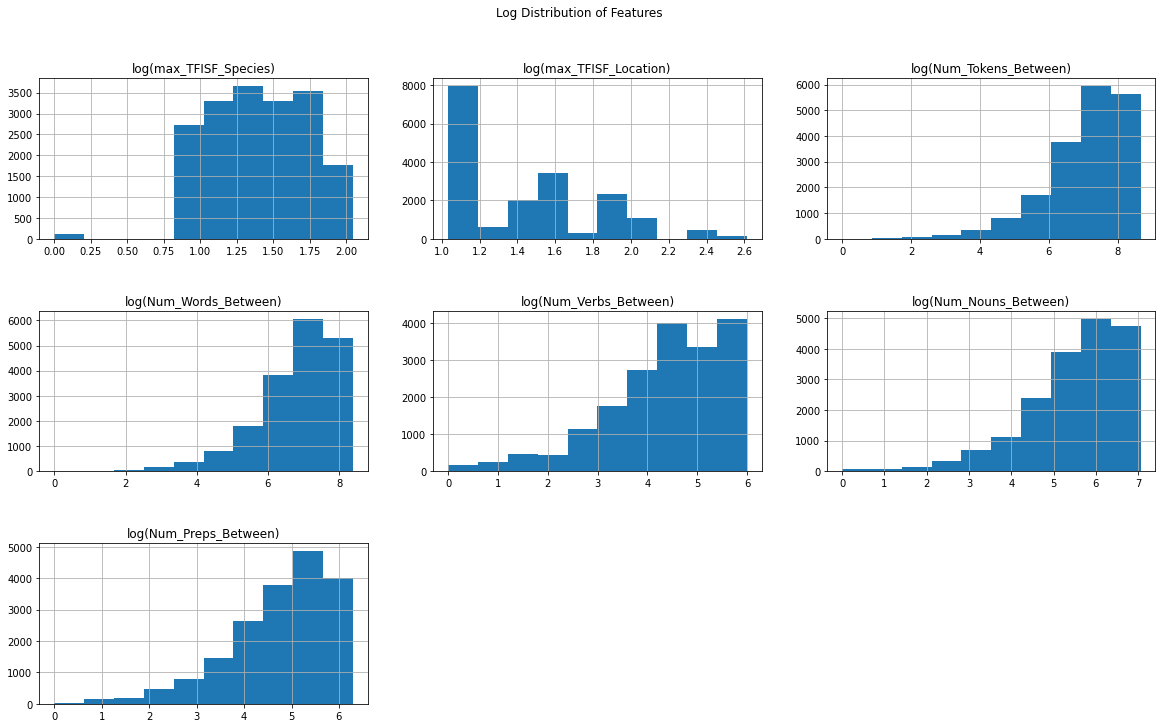

In [16]:
plt.figure(figsize=(20,50))
i=1
for col in possible_transformations: #df['Site'].unique():
    ax = plt.subplot(12,3,i)
    np.log(allPossibleRelationships[col]+1).hist()
    ax.set_title('log('+col+')')
    i += 1
plt.subplots_adjust(hspace=.45)
plt.suptitle("Log Distribution of Features", y=0.9)
plt.show()  

In [17]:
for col in possible_transformations:
    print (col, allPossibleRelationships[col].min(),allPossibleRelationships[col].max())

max_TFISF_Species 0.0 6.724715096691783
max_TFISF_Location 1.8117601359347244 12.628966226199283
Num_Tokens_Between 0 5810
Num_Words_Between 0 4375
Num_Verbs_Between 0 400
Num_Nouns_Between 0 1159
Num_Preps_Between 0 539


In [18]:
%matplotlib inline

rcParams['figure.figsize']  = 15, 10
rcParams['axes.titlesize']  = 20
rcParams['axes.labelsize']  = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 18

In [19]:
for col in possible_transformations:
    name                           = 'sqrt_'+ col
    allPossibleRelationships[name] = np.sqrt(allPossibleRelationships[col])

In [20]:
for col in ['max_TFISF_Species', 'max_TFISF_Location', 'Num_Verbs_Between']:
    name                           = 'log_' + col
    allPossibleRelationships[name] = np.log(allPossibleRelationships[col]+1)

In [21]:
allPossibleRelationships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Species                  18408 non-null  object 
 1   Start_Token_Species      18408 non-null  int64  
 2   End_Token_Species        18408 non-null  int64  
 3   Start_Index_Species      18408 non-null  int64  
 4   End_Index_Species        18408 non-null  int64  
 5   classId_Species          18408 non-null  object 
 6   Sentence_Species         18408 non-null  object 
 7   inAbstract300_Species    18408 non-null  int64  
 8   inAbstract500_Species    18408 non-null  int64  
 9   max_TFISF_Species        18408 non-null  float64
 10  Sent_Start_Species       18408 non-null  int64  
 11  Document                 18408 non-null  object 
 12  AnnTxtFile               18408 non-null  object 
 13  Location                 18408 non-null  object 
 14  Start_Token_Location  

End.